In [ ]:
#installing kaggle library
! pip install kaggle

Upload kaggle.json file

In [ ]:
# configuring the path of kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Importing twitter sentiment dataset

In [ ]:
#API to fetch the dataset from kaggle
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 89% 72.0M/80.9M [00:00<00:00, 110MB/s]
100% 80.9M/80.9M [00:00<00:00, 113MB/s]


In [ ]:
# extracting the compressed dataset

from zipfile import ZipFile
dataset = '/content/sentiment140.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


Importing dependencies

In [ ]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#  printing the stopwords in English
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Data processing

In [ ]:
# loading the data from csv file to pandas dataframe
twitter_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding = 'ISO-8859-1')

In [ ]:
# checking the number of rows and columns
twitter_data.shape

(1599999, 6)

In [ ]:
# printing the first five rows of the dataframe
twitter_data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
# naming the columns and reading the dataset again

column_names = ['target','id','date','flag','user','text']
twitter_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', names=column_names, encoding = 'ISO-8859-1')

In [ ]:
twitter_data.shape

(1600000, 6)

In [ ]:
twitter_data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
# counting the number of missing values in the dataset
twitter_data.isnull().sum()

target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64

In [ ]:
# checking the distribution of target column
twitter_data['target'].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

Converting the target 4 to 1

In [ ]:
twitter_data.replace({'target':{4:1}},inplace=True)

In [ ]:
twitter_data['target'].value_counts()

target
0    800000
1    800000
Name: count, dtype: int64

<Axes: xlabel='id', ylabel='target'>

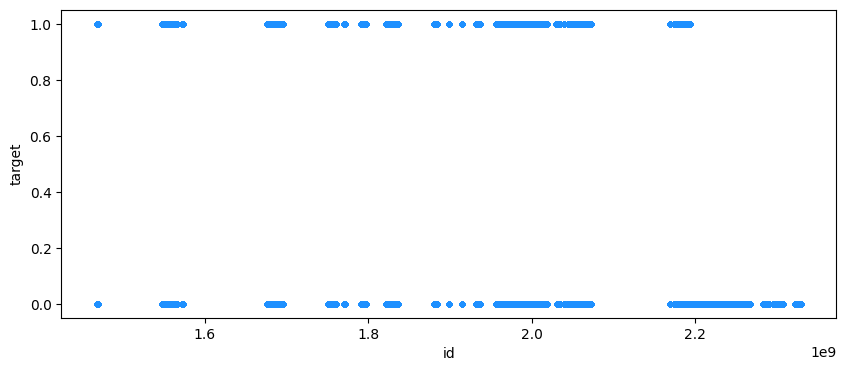

In [ ]:
import matplotlib.pyplot as plt

twitter_data.plot(kind='scatter', x='id', y='target', \
        color='dodgerblue',figsize=(10,4), s=10, alpha=0.5)

0 -> negative tweet
1-> positive tweet

**Stemming**

Stemming is the process of reducing a word to its rootword

In [ ]:
port_stem = PorterStemmer()

In [ ]:
def stemming(content):

  stemmed_content = re.sub('[^a-zA-Z]',' ',content)
  stemmed_content = stemmed_content.lower()
  stemmed_content = stemmed_content.split()
  stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
  stemmed_content = ' '.join(stemmed_content)

  return stemmed_content

In [ ]:
twitter_data['stemmed_content'] = twitter_data['text'].apply(stemming)

In [ ]:
twitter_data.head()

,target,id,date,flag,user,text,stemmed_content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com zl awww bummer sho...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save rest g...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behav mad see


In [ ]:
#separating data and target
X = twitter_data['stemmed_content'].values
Y = twitter_data['target'].values

In [ ]:
print(X)

['switchfoot http twitpic com zl awww bummer shoulda got david carr third day'
 'upset updat facebook text might cri result school today also blah'
 'kenichan dive mani time ball manag save rest go bound' ...
 'readi mojo makeov ask detail'
 'happi th birthday boo alll time tupac amaru shakur'
 'happi charitytuesday thenspcc sparkschar speakinguph h']


In [ ]:
print(Y)

[0 0 0 ... 1 1 1]


**TRAIN - TEST DATA SPLIT**

Splitting the data to training data and test data

In [ ]:
X_train, X_test, Y_train,Y_test = train_test_split(X,Y,test_size=0.2, stratify=Y, random_state=2)

In [ ]:
print(X.shape, X_train.shape, X_test.shape)

(1600000,) (1280000,) (320000,)


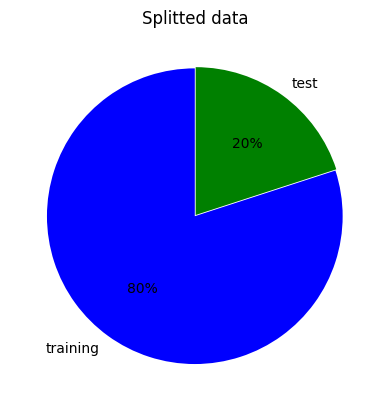

In [ ]:

import matplotlib.pyplot as plt
labels = 'training', 'test'
sections = [1280000,320000]
colors = ['b', 'g']

plt.pie(sections, labels=labels, colors=colors,
        startangle=90,
        explode = (0, 0.01),
        autopct = '%1.f%%')

plt.title('Splitted data')
plt.show()

In [ ]:
print(X_train)

['watch saw iv drink lil wine' 'hatermagazin'
 'even though favourit drink think vodka coke wipe mind time think im gonna find new drink'
 ... 'eager monday afternoon'
 'hope everyon mother great day wait hear guy store tomorrow'
 'love wake folger bad voic deeper']


In [ ]:
print(X_test)

['mmangen fine much time chat twitter hubbi back summer amp tend domin free time'
 'ah may show w ruth kim amp geoffrey sanhueza'
 'ishatara mayb bay area thang dammit' ...
 'destini nevertheless hooray member wonder safe trip' 'feel well'
 'supersandro thank']


In [ ]:
#converting the textual data to numerical data

vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
print(X_train)

  (0, 443066)	0.4484755317023172
  (0, 235045)	0.41996827700291095
  (0, 109306)	0.3753708587402299
  (0, 185193)	0.5277679060576009
  (0, 354543)	0.3588091611460021
  (0, 436713)	0.27259876264838384
  (1, 160636)	1.0
  (2, 288470)	0.16786949597862733
  (2, 132311)	0.2028971570399794
  (2, 150715)	0.18803850583207948
  (2, 178061)	0.1619010109445149
  (2, 409143)	0.15169282335109835
  (2, 266729)	0.24123230668976975
  (2, 443430)	0.3348599670252845
  (2, 77929)	0.31284080750346344
  (2, 433560)	0.3296595898028565
  (2, 406399)	0.32105459490875526
  (2, 129411)	0.29074192727957143
  (2, 407301)	0.18709338684973031
  (2, 124484)	0.1892155960801415
  (2, 109306)	0.4591176413728317
  (3, 172421)	0.37464146922154384
  (3, 411528)	0.27089772444087873
  (3, 388626)	0.3940776331458846
  (3, 56476)	0.5200465453608686
  :	:
  (1279996, 390130)	0.22064742191076112
  (1279996, 434014)	0.2718945052332447
  (1279996, 318303)	0.21254698865277746
  (1279996, 237899)	0.2236567560099234
  (1279996, 2910

In [ ]:
print(X_test)

  (0, 420984)	0.17915624523539803
  (0, 409143)	0.31430470598079707
  (0, 398906)	0.3491043873264267
  (0, 388348)	0.21985076072061738
  (0, 279082)	0.1782518010910344
  (0, 271016)	0.4535662391658828
  (0, 171378)	0.2805816206356073
  (0, 138164)	0.23688292264071403
  (0, 132364)	0.25525488955578596
  (0, 106069)	0.3655545001090455
  (0, 67828)	0.26800375270827315
  (0, 31168)	0.16247724180521766
  (0, 15110)	0.1719352837797837
  (1, 366203)	0.24595562404108307
  (1, 348135)	0.4739279595416274
  (1, 256777)	0.28751585696559306
  (1, 217562)	0.40288153995289894
  (1, 145393)	0.575262969264869
  (1, 15110)	0.211037449588008
  (1, 6463)	0.30733520460524466
  (2, 400621)	0.4317732461913093
  (2, 256834)	0.2564939661498776
  (2, 183312)	0.5892069252021465
  (2, 89448)	0.36340369428387626
  (2, 34401)	0.37916255084357414
  :	:
  (319994, 123278)	0.4530341382559843
  (319995, 444934)	0.3211092817599261
  (319995, 420984)	0.22631428606830145
  (319995, 416257)	0.23816465111736276
  (319995, 3

Training the machine learning model-Logistic regression model

In [ ]:
model = LogisticRegression(max_iter=1000)

In [ ]:
model.fit(X_train,Y_train)

LogisticRegression(max_iter=1000)

Model evaluation

Accuracy score

In [ ]:
#accuracy score on the training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(Y_train, X_train_prediction)

In [ ]:
print('Accuracy score on the training data:',training_data_accuracy)

Accuracy score on the training data: 0.81018984375


In [ ]:
#accuracy score on the test data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(Y_test, X_test_prediction)

In [ ]:
print('Accuracy score on the test data:',test_data_accuracy)

Accuracy score on the test data: 0.7780375


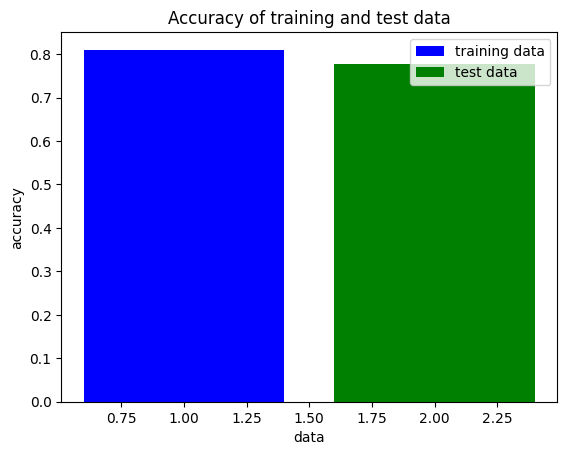

In [ ]:
x1 = 1
y1 = 0.81018984375
x2 = 2
y2 = 0.7780375
plt.bar(x1, y1, label="training data", color='b')
plt.bar(x2, y2, label="test data", color='g')
plt.plot()
plt.xlabel("data")
plt.ylabel("accuracy")
plt.title("Accuracy of training and test data")
plt.legend()
plt.show()

**Model accuracy = 77.8%**

***Predicting using test data***

In [ ]:
X_new = X_test[200]
print(Y_test[200])

prediction = model.predict(X_new)
print(prediction)

if (prediction[0]==0):
  print('Negative tweet')
else:
  print('Positive tweet')

1
[1]
Positive tweet


In [ ]:
X_new = X_test[3]
print(Y_test[3])

prediction = model.predict(X_new)
print(prediction)

if (prediction[0]==0):
  print('Negative tweet')
else:
  print('Positive tweet')

0
[0]
Negative tweet


***Prediction using new data***

In [ ]:
input = 'Today is a good day'
vectorise_input = vectorizer.transform(np.array([input]))

prediction = model.predict(vectorise_input)
if (prediction[0]==1):
  print('Positive')
else:
  print('Negative')

Positive


In [ ]:
input = 'I feel sick'
vectorise_input = vectorizer.transform(np.array([input]))

prediction = model.predict(vectorise_input)
if (prediction[0]==1):
  print('Positive')
else:
  print('Negative')

Negative
